#Time Maps

###Alternate visualization for event occurance rates.


In [1]:
import pandas as pd
import numpy as np
import datetime
from twython import Twython
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
from dateutil.relativedelta import relativedelta
import re

%matplotlib inline

###Get Tweets

Twitter API allows you to gather the 3,200 most recent tweets written by a user. Using Twython, I downloaded tweets from the @FEMA. 

In [2]:
APP_KEY = 'OHwVhvlnggRRisNErbnQlZzNW'
APP_SECRET = '8mretNjRzlpaquepxYFz6Rx4QsZNPdSquz2XkrwKuBWFVx1slD'

user = 'FEMA'
twitter = Twython(APP_KEY, APP_SECRET)
user_timeline = twitter.get_user_timeline(screen_name=user, count = 200, include_rts = 1)
user_timeline
tweets = []
timestamp = []
hashtags = []
while len(user_timeline) != 0: 
    try:
        user_timeline = twitter.get_user_timeline(screen_name=user,
                                                  include_rts = 1,
                                                  count=200,
                                                  max_id=user_timeline[len(user_timeline)-1]['id']-1)
    except TwythonError as e:
        print(e)
    print(len(user_timeline))
    for tweet in user_timeline:
        # Add whatever you want from the tweet, here we just add the text
        timestamp.append(tweet['created_at'])
        
        hashes = []
        for hashtag in tweet['entities']['hashtags']:
            hashes.append(hashtag['text'])
        #hashes = ' '.join(hashes)
        if len(hashes) > 0:
            hashes = hashes[0]
        else:
            hashes = ""
        hashtags.append(hashes)


200
200
200
200
200
200
200
200
200
200
199
200
200
200
200
4
0


###Convert Date to Datetime object

In [5]:
tweets = pd.DataFrame({'time': timestamp, 'hashtags': hashtags})

times = []
for time in tweets.time:
    time = re.sub(string = time, pattern = "\\+0000 ", repl = "")
    times.append(time)
tweets.time = times
tweets.time = pd.to_datetime(tweets.time, format = "%a %b %d %H:%M:%S %Y")
tweets.head()

,hashtags,time
0,opendata,2015-09-28 20:15:32
1,Periscope,2015-09-28 16:16:38
2,FEMACorps,2015-09-28 16:00:04
3,Niala,2015-09-26 16:44:16
4,wildfires,2015-09-25 18:47:24


###Conventional Plot for Occurances

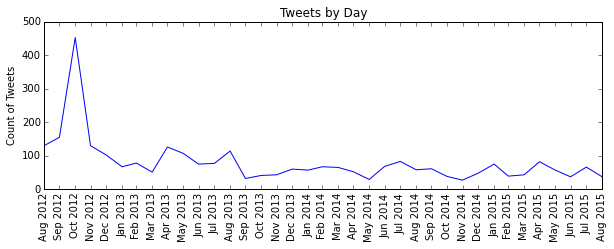

In [9]:

def plot_tweets(data, time_column):
    # Create bins
    min_date = min(data[time_column]).date()
    max_date = max(data[time_column]).date()
    bins = pd.date_range(min_date, max_date, freq='M')


    # Find number of values in Bins
    bin_values = []

    for bin_date in bins:
        bools = (data[time_column] > bin_date) & ((data[time_column] < bin_date + relativedelta(months = 1)))
        value = np.sum(bools)
        bin_values.append(value)

    # Set graph dimensions
    plt.rcParams['figure.figsize'] = 10, 3
    plt.rcParams['figure.dpi'] = 150

    fig, ax = plt.subplots()
    ax.plot_date(bins, bin_values, fmt = 'b-')       
    plt.xticks(bins, bins, rotation = 90)
    plt.ylabel('Count of Tweets')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.title('Tweets by Day')

    plt.show()                

plot_tweets(tweets, "time")

For timeries of events with many short bursts such in our case, a typical time series histogram does not give a lot of information. Although we can see peaks at various times we cannot see what is going on during those "bursts". To do this we would have to subset the data for this periods and make our bins smaller.

###The Alternative: A Time Map
I read about this idea in a recent blog post at District Data Labs:
https://districtdatalabs.silvrback.com/time-maps-visualizing-discrete-events-across-many-timescales 

The author described a technique for visualizing many events across multiple timescales in a single image. It allows the viewer to quickly identify critical features, such as whether events occur on a timescale of milliseconds or months.It also allows the viewer to see if the event is preceded or proceeded by a period of sparse event occurances. It is adopted from the field of chaotic systems, and was originally conceived to study the timing of water drops from a dripping faucet. 

The graphs shows the time from the previous event to an event as well and the time until the next event. The result is the scatter plot below. 

<img src="quadrants_N_medium.png">

##Making a Time Map

###Transforming the Data

In [86]:
def find_intervals(data):
    data = data.sort("time", ascending = 1)
    
    # Seconds Before and After
    data['time_before'] = abs(data.time - data.time.shift(1)) / np.timedelta64(1, 's')
    data['time_after'] = abs(data.time.shift(-1) - data.time) / np.timedelta64(1, 's')
    data = data[1:data.shape[0] - 2]
    return(data)
tweets_map = find_intervals(tweets)
tweets_map.head()

,hashtags,time,time_before,time_after
3001,Isaac,2012-08-31 18:44:23,17122,8142
3000,NatlPrep,2012-08-31 21:00:05,8142,10333
2999,Isaac,2012-08-31 23:52:18,10333,65827
2998,NatlPrep,2012-09-01 18:09:25,65827,78
2997,NatlPrep,2012-09-01 18:10:43,78,3418


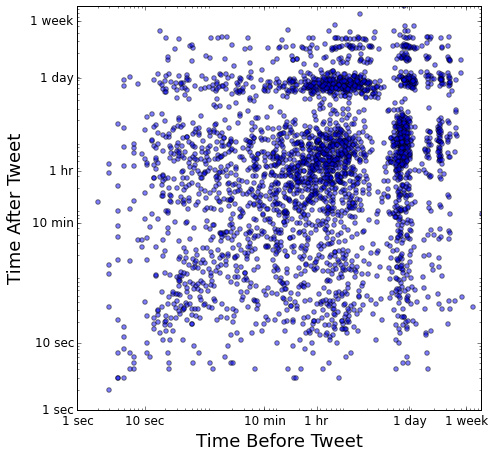

In [18]:
def time_map(tweets):
    plt.close()
    fig, ax = plt.subplots()
    plt.scatter(y = tweets['time_after'], x = tweets['time_before'], alpha = .5)
    plt.rcParams['figure.figsize'] = 7, 7
    plt.rcParams['figure.dpi'] = 50

    ticks = np.array([1,10,600,3600,1*24*3600, 7*24*3600])         # where the tick marks will be placed, in units of seconds. An additional value will be appended to the end for the max
    labels = ['1 sec','10 sec','10 min','1 hr','1 day','1 week']  # tick labels

    ax.set_yscale('log') # logarithmic axes
    ax.set_xscale('log')

    plt.xticks(ticks, labels,fontsize=12)
    plt.yticks(ticks, labels,fontsize=12)

    plt.xlabel('Time Before Tweet',fontsize=18)
    plt.ylabel('Time After Tweet' ,fontsize=18)

    min_val = np.min(tweets['time_before'])
    max_val = np.max(tweets['time_before'])

    plt.xlim((1, 1000000))
    plt.ylim((1, 1000000))

    ax.set_aspect('equal')

    plt.tight_layout()

    plt.show()

time_map(tweets_map)

Now we can see the distinction between the data and it's outliers. The bursts show major events happening while the upper values of the (x, y) axis show really slow periods. By subsetting the bursts of data we can extract the "major events"

Now I want to find the hashtags that occur the most frequently

### Top 20 occuring hashes

In [20]:
hash_count = tweets_map.groupby('hashtags')['time_before'].aggregate(len).order(ascending = False)
hash_count[0:20]

hashtags
                 1008
Sandy             314
NatlPrep           56
RedCross           53
PrepareAthon       49
femathinktank      45
NY                 36
winter             34
Oklahoma           29
hurricane          27
NJ                 25
Katrina10          24
Isaac              21
wx                 21
Winter             20
earthquake         18
safetytip          17
ShakeOut           15
Tornado            15
NYC                14
Name: time_before, dtype: float64

###Hashtags that occur most frequently in less than an hour before and an hour after the previous tweet

In [21]:
hash_count = tweets_map[(tweets_map.time_before < 3600) & 
                        (tweets_map.time_after < 3600)].groupby('hashtags')['time_before'].aggregate(len).order(ascending = False)
hash_count[0:20]

hashtags
                 234
Sandy            126
RedCross          41
femathinktank     15
NJ                14
NY                12
NYC               11
Isaac              9
NatlPrep           9
Oklahoma           9
Tornado            9
PrepareAthon       8
winter             7
coflood            6
wx                 4
noreaster          4
NatlPrepChat       4
sandy              4
earthquake         4
CT                 4
Name: time_before, dtype: float64

In [99]:
# Get top 20 as list
color_labels = hash_count[1:20]
color_labels = list(color_labels.index)

###Locate 8 most rapidly tweeted hashtags

This function will transform a column of ranked items and return all the items above a specified rank and returns "other" for everything below that rank.

In [87]:
def create_hash_group(x, rank_threshold, rank_list):
    if x in rank_list[0:rank_threshold - 1]:
        return x
    else:
        return('other')    

tweets_map['hashtag_groups'] = tweets_map['hashtags'].apply(lambda x : create_hash_group(x = x, top_ten_list = color_labels))


###Create Time_Map with color corresponding to tweets with most occurances

C:\Users\Thomas\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


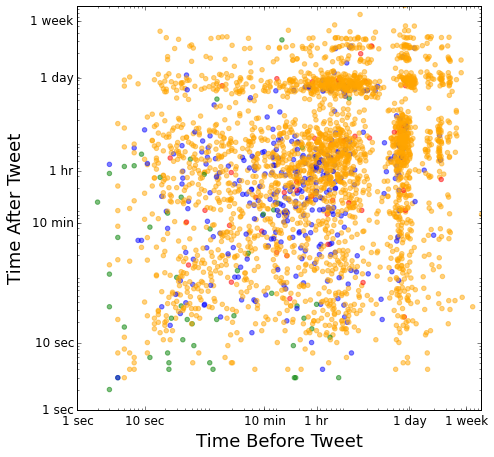

In [98]:
def time_map(tweets, color_labels):
    
    # Allocate Colors to most frequent tweets
    colors = ['blue', 'green', 'red', 'orange', 'black', 'brown', 'yellow', 'purple']
    color_labels = color_labels[0:4]
    color_labels.append('other')
    colors = colors[0:len(color_labels) - 1]
    
    color_dict = {}
    for i in range(len(color_labels)):
        color_dict[color_labels[i-1]] = colors[i-1]
    
    # Create Plot
    plt.close()
    fig, ax = plt.subplots()
    plt.scatter(y = tweets['time_after'], x = tweets['time_before'], alpha = .5, color = [color_dict[i] for i in tweets['hashtag_groups']])
    plt.rcParams['figure.figsize'] = 7, 7
    plt.rcParams['figure.dpi'] = 50
    
    # Alter Scale
    ticks = np.array([1,10,600,3600,1*24*3600, 7*24*3600])         # where the tick marks will be placed, in units of seconds. An additional value will be appended to the end for the max
    labels = ['1 sec','10 sec','10 min','1 hr','1 day','1 week']  # tick labels
    ax.set_yscale('log') # logarithmic axes
    ax.set_xscale('log')

    # Format Labels
    plt.xticks(ticks, labels,fontsize=12)
    plt.yticks(ticks, labels,fontsize=12)
    plt.xlabel('Time Before Tweet',fontsize=18)
    plt.ylabel('Time After Tweet' ,fontsize=18)
    
    # Set Plot Limits
    min_val = np.min(tweets['time_before'])
    max_val = np.max(tweets['time_before'])
    plt.xlim((1, 1000000))
    plt.ylim((1, 1000000))

    ax.set_aspect('equal')
    plt.tight_layout()
    plt.legend()
    plt.show()

time_map(tweets = tweets_map, color_labels = color_labels)
